# Object Detection with SSD on Video

This notebook uses a [PyTorch port](https://github.com/amdegroot/ssd.pytorch) of [SSD: Single Shot MultiBox Detector](https://arxiv.org/abs/1512.02325) to detect objects on a given youtube video.

For other deep-learning Colab notebooks, visit [tugstugi/dl-colab-notebooks](https://github.com/tugstugi/dl-colab-notebooks).


## Install amdegroot/ssd.pytorch

In [0]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/amdegroot/ssd.pytorch.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # clone and install dependencies
  !git clone -q $git_repo_url
  #!cd $project_name && pip install -q -r requirement.txt
  !pip install -q youtube-dl
  
import sys
sys.path.append(project_name)
import time
import matplotlib
import matplotlib.pylab as plt
plt.rcParams["axes.grid"] = False

from IPython.display import YouTubeVideo

## Download the SSD300 pretrained model

In [0]:
PRETRAINED_MODEL_URL = 'https://s3.amazonaws.com/amdegroot-models/ssd300_mAP_77.43_v2.pth'
pretrained_model = basename(PRETRAINED_MODEL_URL)
if not exists(pretrained_model):
  !wget -q $PRETRAINED_MODEL_URL

## Prepare model

In [0]:
# fix some erros
!sed -i 's/HOME = os.path.expanduser("~")/HOME = "$project_name"/' $project_name/data/config.py
!sed -i "s/COCO_ROOT = osp.join(HOME, 'data\/coco\/')/COCO_ROOT = '$project_name\/data'/" $project_name/data/coco.py
!sed -i 's/if scores.dim() == 0/if scores.size(0) == 0/' $project_name/layers/functions/detection.py

import random
import cv2
import numpy as np
import torch

from ssd import build_ssd
from data import VOC_CLASSES as labels
colors = [[random.randint(0, 255) for _ in range(3)] for _ in labels]

# build SS model
net = build_ssd('test', 300, 21)    # initialize SSD
net.load_weights(pretrained_model)
net.eval()
torch.set_grad_enabled(False)

if torch.cuda.is_available():
  net = net.cuda()
# why?
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')

# test on a given image, see: https://github.com/amdegroot/ssd.pytorch/blob/master/demo/demo.ipynb
def test(rgb_image, threshold=0.6):
  # resize to 300x300
  x = cv2.resize(rgb_image, (300, 300)).astype(np.float32)
  # image net mean substract
  x -= (123.0, 117.0, 104.0)
  # image tensor
  x = torch.from_numpy(x.astype(np.float32)).permute(2, 0, 1)
  x = x.unsqueeze(0)
  if torch.cuda.is_available():
    x = x.cuda()
  
  # forward
  t = time.time()
  detections = net(x)
  #print("executed in %.3fs" % (time.time()-t))
  
  # draw boxes and labels
  result_img = np.array(rgb_image)
  scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
  for i in range(detections.size(1)):
    j = 0
    while detections[0,i,j,0] >= threshold:
      score = detections[0,i,j,0]
      label = labels[i-1]
      display_txt = '%s: %.2f'%(label, score)
      pt = (detections[0,i,j,1:]*scale).cpu().numpy()
      color = colors[i-1]

      # draw box
      tl = round(0.002 * max(result_img.shape[0:2])) + 1  # line thickness
      c1, c2 = (int(pt[0]), int(pt[1])), (int(pt[2]), int(pt[3]))
      cv2.rectangle(result_img, c1, c2, color, thickness=tl)

      # draw text
      tf = max(tl - 1, 1)  # font thickness
      t_size = cv2.getTextSize(display_txt, 0, fontScale=tl / 3, thickness=tf)[0]
      c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
      cv2.rectangle(result_img, c1, c2, color, -1)  # filled
      cv2.putText(result_img, display_txt, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)

      j+=1
      
  return result_img

## Detect objects on a test video

We are going to detect objects on the following youtube video:

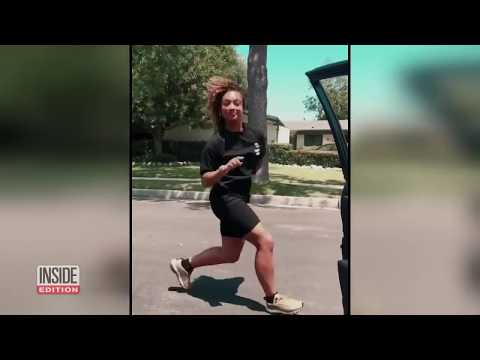

In [4]:
YOUTUBE_ID = 'bQ53oTL2AzU'


YouTubeVideo(YOUTUBE_ID)

First, download the above youtube video:



In [0]:
!rm -df youtube.mp4
# download the youtube with the given ID
!youtube-dl -f 'bestvideo[ext=mp4]' --output "youtube.%(ext)s" https://www.youtube.com/watch?v=$YOUTUBE_ID
# do object detection only on the first 20 seconds...
!ffmpeg -y -loglevel info -i youtube.mp4 -t 20 video.mp4

Now detect objects on the downloaded video:

In [0]:
video_capture = cv2.VideoCapture()
if video_capture.open('video.mp4'):
  width, height = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH)), int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
  fps = video_capture.get(cv2.CAP_PROP_FPS)
  !rm -f output.mp4 output.avi
  # can't write out mp4, so try to write into an AVI file
  video_writer = cv2.VideoWriter("output.avi", cv2.VideoWriter_fourcc(*'MJPG'), fps, (width, height))
  while video_capture.isOpened():
    ret, frame = video_capture.read()
    if not ret:
      break
      
    start = time.time()
    
    rgb_frame = test(frame[:,:,::-1])
    frame = rgb_frame[:,:,::-1]

    end = time.time()
    print("time: {}s, fps: {}".format(end-start, 1/(end-start)))
            
    video_writer.write(frame)
  video_capture.release()
  video_writer.release()
  
  # convert AVI to MP4
  !ffmpeg -y -loglevel info -i output.avi output.mp4
else:
  print("can't open the given input video file!")

Show the result video:

In [0]:
def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

show_local_mp4_video('output.mp4', width=960, height=720)